# Dennis Ting - Streaming Service Home Screen
# Movie Recommender System - 02_Models

**Purpose:** The main purpose of this notebook (02_Models) is to train the various models using the data prepared in the EDA notebook (01_EDA) and assess their performances. 

Please read this notebook in conjunction with my report, and my other notebooks (see report for full outline).

# Section 0 - Import & Functions

## Import Libraries and Packages

In [1]:
# Import Common Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Libraries for Learning
from scipy import sparse
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp
from surprise.model_selection import GridSearchCV

In [3]:
# Libraries for metrics
from surprise import accuracy
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [4]:
# Libraries for Tags NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# Import Joblib to pickle models
import joblib

## Import  Data

In [6]:
# Import Data from 01_EDA
df_train_ratings = pd.read_csv('DT_files/DT_df_rating_train.csv', index_col = 0)
df_test_ratings = pd.read_csv('DT_files/DT_df_rating_test.csv', index_col = 0)
df_tags_of_movies = pd.read_csv('DT_files/DT_df_tags_of_movies.csv', index_col = 0)
df_ratings = pd.read_csv('DT_files/DT_df_ratings.csv', index_col = 0)

In [7]:
# Import MovieLens Data
df_movies = pd.read_csv('data/movies.csv')

## Quick Inspection of data being imported

*`df_train_ratings`*

In [8]:
# Check shape
df_train_ratings.shape

(6558566, 5)

In [9]:
# Visualize
df_train_ratings.head()

,userId,movieId,rating,timestamp,rating_net_user_mean
0,3,1,8,1439472215,1
1,3,29,9,1484754967,2
2,3,32,9,1439474635,2
3,3,50,10,1439474391,3
4,3,111,8,1484753849,1


*`df_test_ratings`*

In [10]:
# Check shape
df_test_ratings.shape

(439850, 5)

In [11]:
# Visualize
df_test_ratings.head()

,userId,movieId,rating,timestamp,rating_net_user_mean
52,3,1732,9,1566091883,2
124,3,4262,9,1566091872,2
467,3,79091,8,1566091612,1
478,3,81834,7,1566091630,0
501,3,87876,7,1566091557,0


*`df_ratings`*

In [12]:
# Check shape
df_ratings.shape

(6998416, 6)

In [13]:
# Visualize
df_ratings.head()

,userId,movieId,rating,timestamp,rating_net_user_mean,test_data
0,3,1,8,1439472215,1,0
1,3,29,9,1484754967,2,0
2,3,32,9,1439474635,2,0
3,3,50,10,1439474391,3,0
4,3,111,8,1484753849,1,0


*`df_tags_of_movies`*

In [14]:
# Check shape
df_tags_of_movies.shape

(24478, 5)

In [15]:
# Visualize
df_tags_of_movies.head()

,movieId,tag,count of tags,title,genres
0,1,Owned imdb top 250 Pixar Pixar ti...,697,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,"Robin Williams time travel fantasy ""b...",180,Jumanji (1995),Adventure|Children|Fantasy
2,3,funny best friend duringcreditsstinger ...,29,Grumpier Old Men (1995),Comedy|Romance
3,4,based on novel or book chick flick divo...,11,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,aging baby confidence contraception ...,24,Father of the Bride Part II (1995),Comedy


*`df_movies`*

In [16]:
# Check shape
df_movies.shape

(62423, 3)

In [17]:
# Visualize
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


##### Summary / Findings:
- Data loaded above in-line with expectations.

# Section 1 - Collaborative Filtering  

## Metrics to look at

I do not have access or ability to collect additional data from the users in the MovieLens database. Thus, I will not be able to collect any "online" data (based on live, real-time scenarios) or metrics (i.e. A/B testing, user's actions, do they actually finish the film, etc).

Thus, I will need to look at offline metrics to measure these models. The biggest advantage of offline evaluations versus online evaluations, is the speed and ease of testing algorithms using predefined datasets, which is exactly what's being done in this project.

Typically a recommender model will be created, tuned, and tested offline. However it is only after running the model (recommender system) in a live scenario where it can be evaluated by usage (i.e. clicking on a recommended movie, etc) that we can truly assess it's impact.

For my offline metrics, I will focus on two metrics: 
- **Fraction of Concordant Pairs (FCP)**
- **Mean Absolute Error (MAE)**

#### Fraction of Concordant Pairs (FCP)

**FCP** is a useful ranking-based metric.

The "Fraction" of Fraction of Concordant Pairs, is calculated based on the all the pairs of movies, what portion of the pairs of movies are concordant pairs. A pair is either concordant (1) or discordant (0), and the math behind calculating FCP is essentially averaging all of these pairs (which are in essence boolean-like, 1 or 0). Thus FCP ranges from 0 to 1 with all pairs of movies being concordant as 1, and none of the pairs of movies being concordant as 0.

*Concordant pair definition & example:*

A concordant pair of ratings is composed of two pairs of ratings, a true rating and a predicted rating, $(r_{1}, \hat{r_{1}})$ and $(r_{2}, \hat{r_{2}})$. If these pairs are concordant, and $r_1 > r_2$, then $\hat{r_1} > \hat{r_2}$. This means that regardless of the predicted values, the order of ratings is correct (i.e. movie 1 is predicted to be preferred to movie 2).

#### Mean Absolute Error (MAE)

**MAE** calculates the average (mean) absolute difference between *actual* rating or net rating (i.e. user rating net user mean rating) and the *predicted* rating or net rating, respectively. Below is the equation of **MAE**:

$$\frac{1}{n}\sum_{ij}|R_{ij}-\hat R_{ij}|$$

Where:
- $n$ stands for the number of scores
- $\hat R_{ij}$ is our prediction 
- $R_{ij}$ is the actual score 

Another metric for measuring the difference between actual and predicted ratings or net ratings is **Root Mean Squared Error (RSME)**. **RSME** is calculated by squaring the difference between actual and predicted ratings or net ratings, summing all of these squared differences, and square rooting that sum. Below is the equation of **RMSE**:

$$\sqrt{\frac{1}{n}\sum_{ij}(R_{ij}-\hat R_{ij})^2}$$

Where:
- $n$ stands for the number of scores
- $\hat R_{ij}$ is our prediction 
- $R_{ij}$ is the actual score 
</br>

As a result of the squaring the differences between actual and predicted ratings or net ratings, **RSME** penalizes large errors more than **MAE**. 



The goal of these models is to provide movie recommendations to users. Having a small portion of the recommendation be movies that are un-related (i.e. "large error") won't itself devalue the other recommendations. Users will likely browse past them and focus on the other recommendations of more interest.

Additionally, the basis of these recommendations is user-generated ratings which are arbitrary to a certain extent (i.e. how is a movie rated as a 7 better than another movie rated as a 6 by a different user, etc). Naturally, I will expect that there will be some fluctuation between actual movie ratings versus predicted movie ratings. Larger errors may appear driven by the arbitrary nature of user-generated ratings, and we should not weigh more penalty to these instances.

As I don't expect large errors (in small quantities) to devalue other recommendations, I do not see a point in penalizing larger errors. Thus, I have selected to track **MAE** over **RSME**.

## Create `df_results`

Below code is to create `df_results` to track metrics discussed above (`fcp` and `mae`). Note, I have put the code in Markdown as I have run this code along with the predictions in future sections below in advance. I have logged the models' metrics into `df_results` and written them to csv. Actual code is to bring the `df_results` in for analysis

```python
# Create dataframe
df_results = pd.DataFrame(columns= ['Algo', 'Train/Test','R/NMR','fcp','mae'])

```

In [18]:
# Import results csv
df_results = pd.read_csv('DT_files/DT_df_results.csv', index_col = 0)
df_results.head(0) # Show headers only

,Algo,Train/Test,R/NMR,fcp,mae


## Set Baseline Expectations with `BaselineOnly()`

Below code is to fit and predict using the `BaselineOnly` in the surprise library to the train and test data to set a baseline expectation on what baseline `fcp` and `mae` scores would be. I will explore the metrics between using the `rating` column or the `rating net_user_mean` ('net rating') column created in EDA notebook (01_EDA).

For efficiencies when re-running the code, I have put the code in markdown and exported the results to `df_results`.

### Baseline for `rating` column

```python

# Set the reader with accurate rating scale
ratings_reader = Reader(rating_scale=(1,10))

# Set the dataset 
train_dataset = Dataset.load_from_df(df_train_ratings[['userId','movieId','rating']], ratings_reader)

# Build Full Train Set
ratings_trainset = train_dataset.build_full_trainset()

# Instantiate model and Fit model
Baseline_model_r = BaselineOnly().fit(ratings_trainset)

# Train & Test Data

# Filter `df_train_ratings` to - user ID, movie ID, rating
df_train_r = df_train_ratings[['userId','movieId','rating']]

# Convert df to array to list
list_train_r = df_train_r.to_numpy().tolist()

# Filter `df_test_ratings` to - user ID, movie ID, rating
df_test_r = df_test_ratings[['userId','movieId','rating']]

# Convert df to array to list
list_test_r = df_test_r.to_numpy().tolist()

# Train prediction
Baseline_train_prediction_r = Baseline_model_r.test(list_train_r)

# Test prediction
Baseline_test_prediction_r = Baseline_model_r.test(list_test_r)

```

#### Train Score

```python

# Add accuracy info to `df_results`
in_algo = 'Baseline'
in_traintest = 'Train'
in_r_nmr ='r'
in_fcp = accuracy.fcp(Baseline_train_prediction_r)
in_mae = accuracy.mae(Baseline_train_prediction_r)


row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [19]:
# Show results
df_results.iloc[0:1,:]

,Algo,Train/Test,R/NMR,fcp,mae
0,Baseline,Train,r,0.695704,1.267101


#### Test Score

```python

# Add accuracy info to `df_results`
in_algo = 'Baseline'
in_traintest = 'Test'
in_r_nmr ='r'
in_fcp = accuracy.fcp(Baseline_test_prediction_r)
in_mae = accuracy.mae(Baseline_test_prediction_r)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [20]:
# Show results
df_results.iloc[1:2,:]

,Algo,Train/Test,R/NMR,fcp,mae
1,Baseline,Test,r,0.62133,1.340069


##### Summary / Findings:
- I will review Baseline results in aggregate below in the code titled "Look at Baseline results together".

### Baseline for `rating_net_user_mean` column

```python

# Set the reader with accurate rating scale
ratings_reader_user_mean = Reader(rating_scale=(-10,10))

# Set the dataset
train_dataset_user_mean = Dataset.load_from_df(df_train_ratings[['userId','movieId','rating_net_user_mean']], ratings_reader_user_mean)

# Build Full Train Set
net_user_mean_ratings_trainset = train_dataset_user_mean.build_full_trainset()


# Instantiate model and Fit model
Baseline_model_nmr = BaselineOnly().fit(net_user_mean_ratings_trainset)

# Train & Test Data

# Filter `df_train_ratings` to - user ID, movie ID, rating
df_train_nmr = df_train_ratings[['userId','movieId','rating_net_user_mean']]

# Convert df to array to list
list_train_nmr = df_train_nmr.to_numpy().tolist()

# Filter `df_test_ratings` to - user ID, movie ID, rating
df_test_nmr = df_test_ratings[['userId','movieId','rating_net_user_mean']]

# Convert df to array to list
list_test_nmr = df_test_nmr.to_numpy().tolist()

# Train prediction
Baseline_train_prediction_nmr = Baseline_model_nmr.test(list_train_nmr)

# Test prediction
Baseline_test_prediction_nmr = Baseline_model_nmr.test(list_test_nmr)

```

#### Train Score

```python

# Add accuracy info to `df_results`
in_algo = 'Baseline'
in_traintest = 'Train'
in_r_nmr ='nmr'
in_fcp = accuracy.fcp(Baseline_train_prediction_nmr)
in_mae = accuracy.mae(Baseline_train_prediction_nmr)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [21]:
# Show results
df_results.iloc[2:3,:]

,Algo,Train/Test,R/NMR,fcp,mae
2,Baseline,Train,nmr,0.694906,1.260692


#### Test Score

```python

# Add accuracy info to `df_results`
in_algo = 'Baseline'
in_traintest = 'Test'
in_r_nmr ='nmr'
in_fcp = accuracy.fcp(Baseline_test_prediction_nmr)
in_mae = accuracy.mae(Baseline_test_prediction_nmr)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [22]:
# Show results
df_results.iloc[3:4,:]

,Algo,Train/Test,R/NMR,fcp,mae
3,Baseline,Test,nmr,0.621751,1.283663


##### Summary / Findings:
- I will review Baseline results in aggregate below in the code titled "Look at Baseline results together".

### Look at Baseline results together

In [23]:
# Show Baseline Results
df_results[df_results['Algo'] == 'Baseline']

,Algo,Train/Test,R/NMR,fcp,mae
0,Baseline,Train,r,0.695704,1.267101
1,Baseline,Test,r,0.621330,1.340069
2,Baseline,Train,nmr,0.694906,1.260692
3,Baseline,Test,nmr,0.621751,1.283663


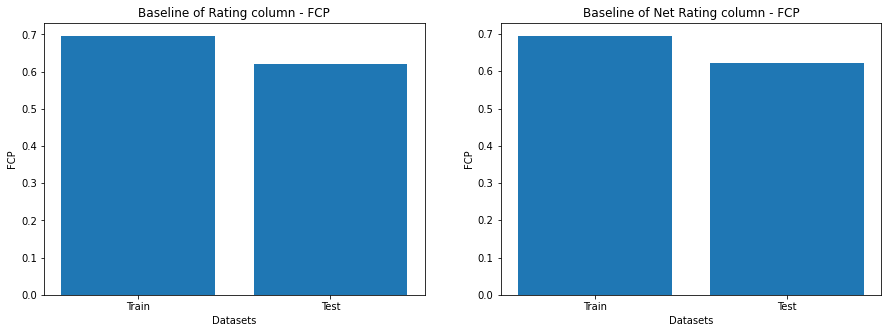

In [24]:
# Plot metrics

# Overall Variables
graph_algo = 'Baseline'
graph_metric = 'fcp'

plt.subplots(1,2, figsize = (15,5))


# Plot 1
plt.subplot(1,2,1)

# Variables
graph_col = 'Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')


# Plot 2
plt.subplot(1,2,2)

# Variables
graph_col = 'Net Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')


# Show the subplots
plt.tight_layout
plt.show()

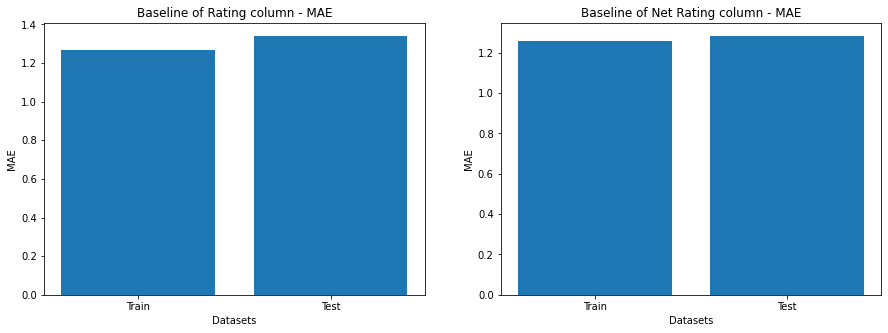

In [25]:
# Plot metrics

# Overall Variables
graph_algo = 'Baseline'
graph_metric = 'mae'

plt.subplots(1,2, figsize = (15,5))


# Plot 1
plt.subplot(1,2,1)

# Variables
graph_col = 'Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')


# Plot 2
plt.subplot(1,2,2)

# Variables
graph_col = 'Net Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')


# Show the subplots
plt.tight_layout
plt.show()

##### Summary / Findings:
- It appears that for both models trained, fitted, and scored on the `rating` column and the `rating_net_user_mean` (net rating) column had similar performance:
    - `fcp`:
        - Train set ~ 0.695 for both
        - Test set ~ 0.621 for both
    - `mae`:
        - Train set ~ 1.26 for both
        - Test set ~ 1.34 for `rating` column generated model, and ~ 1.28 `rating_net_user_mean` (net rating) column generated model
- It appears that the Baseline model using `rating_net_user_mean` (net rating) column performed slightly better than the other model.

## Perform Grid Search (Funk SVD)

I performed Grid Searches to fine tune the hyperparameters for the Funk SVD models below (one for `rating` column, and the other for the `rating_net_user_mean` column). The below Grid Searches took between 12 and 24 hours to run in total. Thus, I have instead put the code in markdown and exported the findings to csv. </br>
</br>
For the sake of run-time, I used a 3 fold cross validation instead of the 5 fold cross validation that is default for `GridSearchCV`.

#### Parameters for SVD
Before performing the grid search, I will describe the various parameters of Grid Search we are adjusting for:
- `n_factors` – The number of factors. These are latent features (i.e. hidden features) related to users and movies.
- `n_epochs` – The number of iteration of the Stochastic Gradient Descent procedure (iterations to adjust factors to minimize error). 
- `lr_all` – The learning rate for all parameters. This is the parameter that controls how much to adjust the model in response to estimated errors.
- `biased` – Boolean. True to use baselines or False for biases.

### Run Grid Search for `rating` column

```python
# Set the reader with accurate rating scale
ratings_reader = Reader(rating_scale=(1,10))

# Set the dataset 
train_dataset = Dataset.load_from_df(df_train_ratings[['userId','movieId','rating']], ratings_reader)

# Set the parameter grid
param_grid = {
    'n_factors': [25, 100, 200], 
    'n_epochs': [5, 10, 20],
    'lr_all': [0.005, 0.01, 0.1],
    'biased': [False] }


# Set GridSearchCV with 3 fold cross validation 
GS = GridSearchCV(SVD, param_grid, measures=['fcp', 'mae'], cv=3, joblib_verbose=5)

# Fit the model
GS.fit(train_dataset)

# Put Grid Search results into a DataFrame
df_GS_results = pd.DataFrame(GS.cv_results)

# Write to csv 
df_GS_results.to_csv('DT_files/DT_GS_results_ratings.csv')

```

### Run Grid Search for `rating_net_user_mean` column

```python

# Set the reader with accurate rating scale
ratings_reader_user_mean = Reader(rating_scale=(-10,10))

# Set the dataset
train_dataset_user_mean = Dataset.load_from_df(df_train_ratings[['userId','movieId','rating_net_user_mean']], ratings_reader_user_mean)

# Set the parameter grid
param_grid = {
    'n_factors': [25, 100, 200], 
    'n_epochs': [5, 10, 20],
    'lr_all': [0.005, 0.01, 0.1],
    'biased': [False] }

# Set GridSearchCV with 3 cross validation
GS_user_mean = GridSearchCV(SVD, param_grid, measures=['fcp', 'mae'], cv=3, joblib_verbose=5)

# Fit the model
GS_user_mean.fit(train_dataset_user_mean)

# Put Grid Search results into a DataFrame
df_GS_results_user_mean = pd.DataFrame(GS_user_mean.cv_results)

# Write to csv 
df_GS_results_user_mean.to_csv('DT_files/DT_GS_results_user_mean_ratings.csv')

```

I could have pickled the Grid Searches above, however for reproducibility and memory sake the results themselves are sufficient. </br>
</br>
Below I will perform code to analyze the results from the Grid Searches performed above.

In [26]:
# Import Grid Search Results

# `rating` column
df_GS_results = pd.read_csv('DT_files/DT_GS_results_ratings.csv', index_col = 0)

# `rating_net_user_mean` column
df_GS_results_user_mean = pd.read_csv('DT_files/DT_GS_results_user_mean_ratings.csv', index_col = 0)

*Visualize - both set of results should be in the same format*

In [27]:
# Visualize 
df_GS_results.head(1) 

,split0_test_fcp,split1_test_fcp,split2_test_fcp,mean_test_fcp,std_test_fcp,rank_test_fcp,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_biased
0,0.721096,0.718796,0.720456,0.720116,0.000969,12,1.248385,1.249877,1.248785,1.249015,...,18,22.753826,0.423304,19.673066,2.311413,"{'n_factors': 25, 'n_epochs': 5, 'lr_all': 0.0...",25,5,0.005,False


In [28]:
# Visualize
df_GS_results_user_mean.head(1)

,split0_test_fcp,split1_test_fcp,split2_test_fcp,mean_test_fcp,std_test_fcp,rank_test_fcp,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_biased
0,0.719133,0.720319,0.719038,0.719497,0.000582,12,1.198207,1.197186,1.199832,1.198408,...,16,22.895919,0.322961,19.833965,1.572266,"{'n_factors': 25, 'n_epochs': 5, 'lr_all': 0.0...",25,5,0.005,False


*Look at column names - both set of results should be in the same format*

In [29]:
# Column names 
df_GS_results.columns

Index(['split0_test_fcp', 'split1_test_fcp', 'split2_test_fcp',
       'mean_test_fcp', 'std_test_fcp', 'rank_test_fcp', 'split0_test_mae',
       'split1_test_mae', 'split2_test_mae', 'mean_test_mae', 'std_test_mae',
       'rank_test_mae', 'mean_fit_time', 'std_fit_time', 'mean_test_time',
       'std_test_time', 'params', 'param_n_factors', 'param_n_epochs',
       'param_lr_all', 'param_biased'],
      dtype='object')

In [30]:
# Column names 
df_GS_results_user_mean.columns

Index(['split0_test_fcp', 'split1_test_fcp', 'split2_test_fcp',
       'mean_test_fcp', 'std_test_fcp', 'rank_test_fcp', 'split0_test_mae',
       'split1_test_mae', 'split2_test_mae', 'mean_test_mae', 'std_test_mae',
       'rank_test_mae', 'mean_fit_time', 'std_fit_time', 'mean_test_time',
       'std_test_time', 'params', 'param_n_factors', 'param_n_epochs',
       'param_lr_all', 'param_biased'],
      dtype='object')

##### Summary / Findings:
- I have successfully performed Grid Search for SVD. I will analyze the results of this Grid Search below.

## Analyze Grid Search Results

### `rating` column

In [31]:
# FCP accuracy score (1.0 is ideal and 0 is worst) - Max score
print(f"Max FCP score: {round(df_GS_results['mean_test_fcp'].max(),3)}")

# Mean Absolute Error (MAE) - lower is better 
print(f"Min MAE: {round(df_GS_results['mean_test_mae'].min(),3)}")

Max FCP score: 0.741
Min MAE: 1.145


In [32]:
# Get Parameters of Top performing model - based on fcp accuracy score
df_GS_results.sort_values('mean_test_fcp', ascending=False)['params'].iloc[0,]
    # sort values from largest to smallest for fcp accuracy score
    # keep params columns.
    # filter for first row

"{'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False}"

In [33]:
# Get Parameters of Top performing model - based on lowest MAE
df_GS_results.sort_values('mean_test_mae', ascending=True)['params'].iloc[0,]
    # sort values from smallest to largest for MAE
    # keep params columns.
    # filter for first row

"{'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False}"

#### Look at hyperparameters and how they performed against each other

**fcp**

In [34]:
# n_factors
df_GS_results.groupby('param_n_factors')['mean_test_fcp'].max()

param_n_factors
25     0.740953
100    0.738228
200    0.736961
Name: mean_test_fcp, dtype: float64

In [35]:
# n_epochs
df_GS_results.groupby('param_n_epochs')['mean_test_fcp'].max()

param_n_epochs
5     0.732505
10    0.738517
20    0.740953
Name: mean_test_fcp, dtype: float64

In [36]:
# lr_all
df_GS_results.groupby('param_lr_all')['mean_test_fcp'].max()

param_lr_all
0.005    0.740953
0.010    0.733209
0.100    0.000000
Name: mean_test_fcp, dtype: float64

**mae**

In [37]:
# n_factors
df_GS_results.groupby('param_n_factors')['mean_test_mae'].min()

param_n_factors
25     1.144506
100    1.158275
200    1.162814
Name: mean_test_mae, dtype: float64

In [38]:
# n_epochs
df_GS_results.groupby('param_n_epochs')['mean_test_mae'].min()

param_n_epochs
5     1.217170
10    1.158275
20    1.144506
Name: mean_test_mae, dtype: float64

In [39]:
# lr_all
df_GS_results.groupby('param_lr_all')['mean_test_mae'].min()

param_lr_all
0.005    1.144506
0.010    1.188511
0.100    2.862567
Name: mean_test_mae, dtype: float64

**Visualize**


Grid Search Results - Rating Column



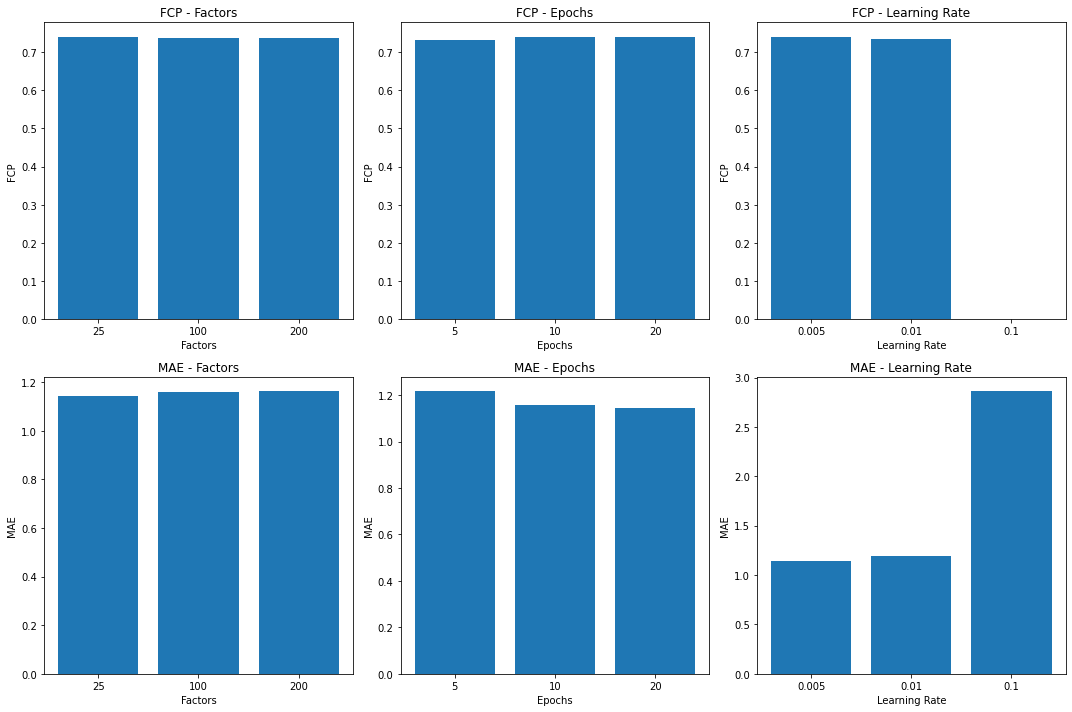

In [40]:
# Visualize Grid Search Results
print('') # Intentionally left blank, for spacing
print("Grid Search Results - Rating Column")
print('') # Intentionally left blank, for spacing

# Set up graph variables
v_in_1 = df_GS_results.groupby('param_n_factors')['mean_test_fcp'].max()
v_in_2 = df_GS_results.groupby('param_n_epochs')['mean_test_fcp'].max()
v_in_3 = df_GS_results.groupby('param_lr_all')['mean_test_fcp'].max()
v_in_4 = df_GS_results.groupby('param_n_factors')['mean_test_mae'].min()
v_in_5 = df_GS_results.groupby('param_n_epochs')['mean_test_mae'].min()
v_in_6 = df_GS_results.groupby('param_lr_all')['mean_test_mae'].min()

list_v_in = [v_in_1, v_in_2, v_in_3, v_in_4, v_in_5, v_in_6]
list_v_title = ['FCP - Factors', 'FCP - Epochs', 'FCP - Learning Rate', \
                'MAE - Factors', 'MAE - Epochs', 'MAE - Learning Rate']
list_v_x = ['Factors', 'Epochs', 'Learning Rate', \
            'Factors', 'Epochs', 'Learning Rate']
list_v_y = ['FCP', 'FCP', 'FCP', 'MAE', 'MAE', 'MAE']

plt.subplots(2,3, figsize=(15,10))

for plot_i in range (0,6):
    
    plt.subplot(2,3,plot_i+1)
    
    # Bar Graph
    plt.bar(list_v_in[plot_i].index.astype('str'), 
            list_v_in[plot_i].values)

    # Titles and axis
    plt.title(list_v_title[plot_i])
    plt.xlabel(list_v_x[plot_i])
    plt.ylabel(list_v_y[plot_i])


plt.tight_layout()
plt.show()

##### Summary / Findings:
Below are the insights I have gathered from my Grid Search results above.

- The best model from the Grid Search under both `fcp` and `mae` metrics has the following parameters:
    - {'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False} </br>
</br>

- A look into the parameters and how they performed.
    - Lower Factors lead to higher `fcp` and lower `mae` (i.e. favourable).
        - This is surprising as I would generally expect more favourable results with more latent factors. 
    - Higher Epochs lead to higher `fcp` and lower `mae` (i.e. favourable).
        - It appears that the model benefitted from the additional fine tuning with higher epochs.
    - Lower Learning Rate lead to higher `fcp` and lower `mae` (i.e. favourable).
        - It appears that a lower learning rate was better suited to fine tune the model.

### `rating_net_user_mean` column

In [41]:
# FCP accuracy score (1.0 is ideal and 0 is worst) - Max score
print(f"Max FCP score: {round(df_GS_results_user_mean['mean_test_fcp'].max(),3)}")

# Mean Absolute Error (MAE) - lower is better 
print(f"Min MAE: {round(df_GS_results_user_mean['mean_test_mae'].min(),3)}")

Max FCP score: 0.743
Min MAE: 1.144


In [42]:
# Get Parameters of Top performing model
df_GS_results_user_mean.sort_values('mean_test_fcp', ascending=False)['params'].iloc[0,]
    # sort values from largest to smallest for fcp accuracy score
    # keep params columns.
    # filter for first row

"{'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False}"

In [43]:
# Get Parameters of Top performing model - based on lowest MAE
df_GS_results_user_mean.sort_values('mean_test_mae', ascending=True)['params'].iloc[0,]
    # sort values from smallest to largest for MAE
    # keep params columns.
    # filter for first row

"{'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False}"

#### Look at hyperparameters and how they performed against each other

**fcp**

In [44]:
# n_factors
df_GS_results_user_mean.groupby('param_n_factors')['mean_test_fcp'].max()

param_n_factors
25     0.742752
100    0.738280
200    0.735814
Name: mean_test_fcp, dtype: float64

In [45]:
# n_epochs
df_GS_results_user_mean.groupby('param_n_epochs')['mean_test_fcp'].max()

param_n_epochs
5     0.738107
10    0.739313
20    0.742752
Name: mean_test_fcp, dtype: float64

In [46]:
# lr_all
df_GS_results_user_mean.groupby('param_lr_all')['mean_test_fcp'].max()

param_lr_all
0.005    0.742752
0.010    0.738174
0.100    0.000000
Name: mean_test_fcp, dtype: float64

**mae**

In [47]:
# n_factors
df_GS_results_user_mean.groupby('param_n_factors')['mean_test_mae'].min()

param_n_factors
25     1.143986
100    1.146410
200    1.154413
Name: mean_test_mae, dtype: float64

In [48]:
# n_epochs
df_GS_results_user_mean.groupby('param_n_epochs')['mean_test_mae'].min()

param_n_epochs
5     1.149150
10    1.144142
20    1.143986
Name: mean_test_mae, dtype: float64

In [49]:
# lr_all
df_GS_results_user_mean.groupby('param_lr_all')['mean_test_mae'].min()

param_lr_all
0.005     1.143986
0.010     1.149150
0.100    10.000652
Name: mean_test_mae, dtype: float64

**Visualize**


Grid Search Results - Net Rating Column



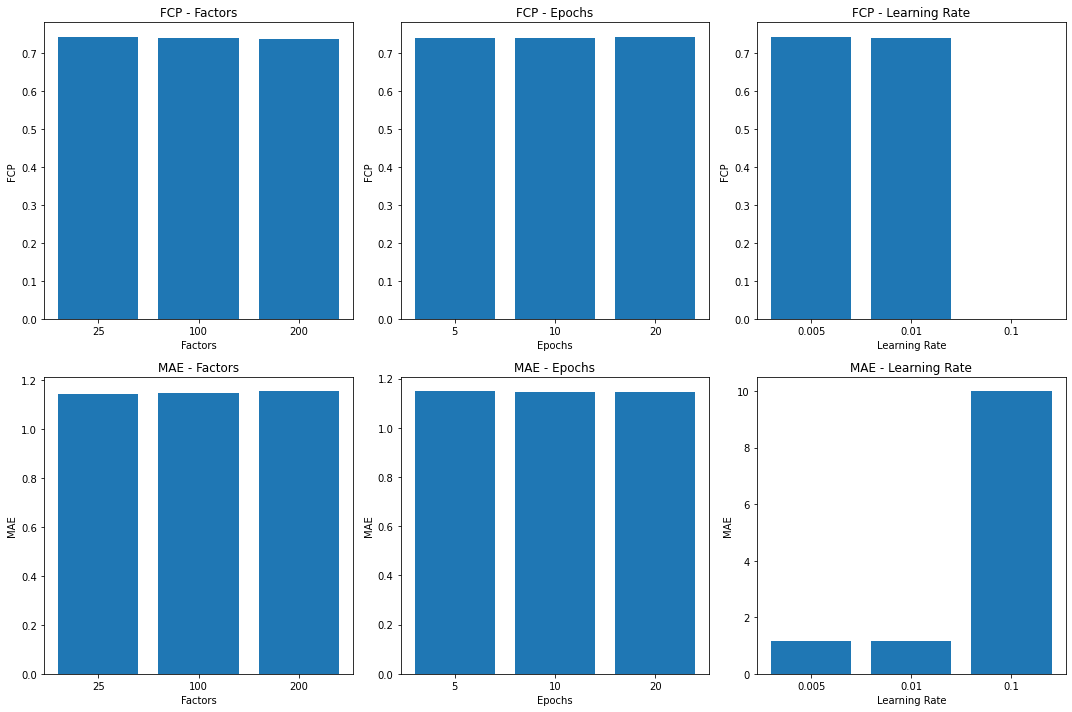

In [50]:
# Visualize Grid Search Results
print('') # Intentionally left blank, for spacing
print("Grid Search Results - Net Rating Column")
print('') # Intentionally left blank, for spacing

# Set up graph variables
v_in_1 = df_GS_results_user_mean.groupby('param_n_factors')['mean_test_fcp'].max()
v_in_2 = df_GS_results_user_mean.groupby('param_n_epochs')['mean_test_fcp'].max()
v_in_3 = df_GS_results_user_mean.groupby('param_lr_all')['mean_test_fcp'].max()
v_in_4 = df_GS_results_user_mean.groupby('param_n_factors')['mean_test_mae'].min()
v_in_5 = df_GS_results_user_mean.groupby('param_n_epochs')['mean_test_mae'].min()
v_in_6 = df_GS_results_user_mean.groupby('param_lr_all')['mean_test_mae'].min()

list_v_in = [v_in_1, v_in_2, v_in_3, v_in_4, v_in_5, v_in_6]
list_v_title = ['FCP - Factors', 'FCP - Epochs', 'FCP - Learning Rate', \
                'MAE - Factors', 'MAE - Epochs', 'MAE - Learning Rate']
list_v_x = ['Factors', 'Epochs', 'Learning Rate', \
            'Factors', 'Epochs', 'Learning Rate']
list_v_y = ['FCP', 'FCP', 'FCP', 'MAE', 'MAE', 'MAE']

plt.subplots(2,3, figsize=(15,10))

for plot_i in range (0,6):
    
    plt.subplot(2,3,plot_i+1)
    
    # Bar Graph
    plt.bar(list_v_in[plot_i].index.astype('str'), 
            list_v_in[plot_i].values)

    # Titles and axis
    plt.title(list_v_title[plot_i])
    plt.xlabel(list_v_x[plot_i])
    plt.ylabel(list_v_y[plot_i])


plt.tight_layout()
plt.show()

##### Summary / Findings:
Below are the insights I have gathered from my Grid Search results above.

- The best model from the Grid Search under both `fcp` and `mae` metrics has the following parameters:
    - {'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False} </br>
</br>

- A look into the parameters and how they performed.
    - Lower Factors lead to higher `fcp` and lower `mae` (i.e. favourable).
        - This is surprising as I would generally expect more favourable results with more latent factors. 
    - Higher Epochs lead to higher `fcp` and lower `mae` (i.e. favourable).
        - It appears that the model benefitted from the additional fine tuning with higher epochs.
    - Lower Learning Rate lead to higher `fcp` and lower `mae` (i.e. favourable).
        - It appears that a lower learning rate was better suited to fine tune the model.

### Overall Grid Search Results

##### Summary / Findings:
- The unanimous best model from the Grid Search under both `fcp` and `mae` metrics and both `rating` or `rating_net_user_mean` (net rating) columns is:
    - {'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False} </br>
</br>
- A look into the parameters and how they performed.
    - Lower Factors lead to higher `fcp` and lower `mae` (i.e. favourable).
        - This is surprising as I would generally expect more favourable results with more latent factors. 
    - Higher Epochs lead to higher `fcp` and lower `mae` (i.e. favourable).
        - It appears that the model benefitted from the additional fine tuning with higher epochs.
    - Lower Learning Rate lead to higher `fcp` and lower `mae` (i.e. favourable).
        - It appears that a lower learning rate was better suited to fine tune the model.

## Model - SVD

In this section, I will fit the unanimous best model from Grid Search above to the `rating` and `rating_net_user_mean` (net rating) columns. I will predict and score these models based on `fcp` and `mae`. 

For efficiencies when re-running the code, I have put the code in markdown and pickled the models. I have also stored scores (`fcp` and `mae`) in `df_results`, which I exported to csv (this code is in markdown as well).

- The unanimous best model from the Grid Search:
    - {'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'biased': False} </br>

### SVD Model - `rating` column

```python

# Set the reader with accurate rating scale
ratings_reader = Reader(rating_scale=(1,10))

# Set the dataset 
train_dataset = Dataset.load_from_df(df_train_ratings[['userId','movieId','rating']], ratings_reader)

# Build Full Train Set
ratings_trainset = train_dataset.build_full_trainset()

# Set the parameters for SVD
ratings_svd = SVD(n_factors=25, 
                  n_epochs=20, 
                  lr_all=0.005, 
                  biased=False,
                  verbose=5)

# Fit train set
ratings_svd.fit(ratings_trainset)

# Pickle the model
joblib.dump(ratings_svd, 'DT_files/DT_ratings_svd.pkl')

```

### SVD Model - `rating_net_user_mean` column

```python

# Set the reader with accurate rating scale
ratings_reader_user_mean = Reader(rating_scale=(-10,10))

# Set the dataset
train_dataset_user_mean = Dataset.load_from_df(df_train_ratings[['userId','movieId','rating_net_user_mean']], ratings_reader_user_mean)

# Build Full Train Set
net_user_mean_ratings_trainset = train_dataset_user_mean.build_full_trainset()

# Set the parameters for SVD
net_user_mean_ratings_svd = SVD(n_factors=25, 
                                n_epochs=20, 
                                lr_all=0.005, 
                                biased=False, 
                                verbose=5)

# Fit train set
net_user_mean_ratings_svd.fit(net_user_mean_ratings_trainset)

# Pickle the model
joblib.dump(net_user_mean_ratings_svd, 'DT_files/DT_net_user_mean_ratings_svd.pkl')

```

The below code is for importing models. This code can be used if we want to run the fitting, prediction, and scoring below without rerunning the above.

```python

# Import models

# model for `rating` column
ratings_svd = joblib.load('DT_files/DT_ratings_svd.pkl')

# model for `net_user_mean_rating` column
net_user_mean_ratings_svd = joblib.load('DT_files/DT_net_user_mean_ratings_svd.pkl')

```

## Train Dataset

**SVD Model - `rating` column**

```python

# Filter `df_train_ratings` to - user ID, movie ID, rating
df_train_r = df_train_ratings[['userId','movieId','rating']]

# Convert df to array to list
list_train_r = df_train_r.to_numpy().tolist()

# Predict
train_pred_r = ratings_svd.test(list_train_r)

# Put into a dataframe
df_train_pred_r = pd.DataFrame(train_pred_r, columns=['userId',
                                                    'movieId',
                                                    'actual_rating',
                                                    'prediction',
                                                    'details'])

# Add accuracy info to `df_results`
in_algo = 'SVD'
in_traintest = 'Train'
in_r_nmr ='r'
in_fcp = accuracy.fcp(train_pred_r)
in_mae = accuracy.mae(train_pred_r)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [51]:
# Show results
df_results.iloc[4:5,:]

,Algo,Train/Test,R/NMR,fcp,mae
4,SVD,Train,r,0.781888,1.003606


##### Summary / Findings:
- I will review SVD results in aggregate below in the code titled "Look at SVD results together".

**SVD Model - `rating_net_user_mean` column**

```python

# Filter `df_train_ratings` to - user ID, movie ID, rating
df_train_nmr = df_train_ratings[['userId','movieId','rating_net_user_mean']]

# Convert df to array to list
list_train_nmr = df_train_nmr.to_numpy().tolist()

# Predict
train_pred_nmr = net_user_mean_ratings_svd.test(list_train_nmr)

# Put into a dataframe
df_train_pred_nmr = pd.DataFrame(train_pred_nmr, columns=['userId', 
                                                        'movieId',
                                                        'actual_rating_net_user_mean',
                                                        'prediction',
                                                        'details'])

# Add accuracy info to `df_results`
in_algo = 'SVD'
in_traintest = 'Train'
in_r_nmr ='nmr'
in_fcp = accuracy.fcp(train_pred_nmr)
in_mae = accuracy.mae(train_pred_nmr)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [52]:
# Show results
df_results.iloc[5:6,:]

,Algo,Train/Test,R/NMR,fcp,mae
5,SVD,Train,nmr,0.793119,0.964372


##### Summary / Findings:
- I will review SVD results in aggregate below in the code titled "Look at SVD results together".

## Test Dataset

**SVD Model - `rating` column**

```python

# Filter `df_test_ratings` to - user ID, movie ID, rating
df_test_r = df_test_ratings[['userId','movieId','rating']]

# Convert df to array to list
list_test_r = df_test_r.to_numpy().tolist()

# Predict
test_pred_r = ratings_svd.test(list_test_r)

# Put into a dataframe
df_test_pred_r = pd.DataFrame(test_pred_r, columns=['userId',
                                                    'movieId',
                                                    'actual_rating',
                                                    'prediction',
                                                    'details'])

in_algo = 'SVD'
in_traintest = 'Test'
in_r_nmr ='r'
in_fcp = accuracy.fcp(test_pred_r)
in_mae = accuracy.mae(test_pred_r)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [53]:
# Show results
df_results.iloc[6:7,:]

,Algo,Train/Test,R/NMR,fcp,mae
6,SVD,Test,r,0.65692,1.245596


##### Summary / Findings:
- I will review SVD results in aggregate below in the code titled "Look at SVD results together".

**SVD Model - `rating_net_user_mean` column**

```python

# Filter `df_test_ratings` to - user ID, movie ID, rating
df_test_nmr = df_test_ratings[['userId','movieId','rating_net_user_mean']]

# Convert df to array to list
list_test_nmr = df_test_nmr.to_numpy().tolist()

# Predict
test_pred_nmr = net_user_mean_ratings_svd.test(list_test_nmr)

# Put into a dataframe
df_test_pred_nmr = pd.DataFrame(test_pred_nmr, columns=['userId', 
                                                        'movieId',
                                                        'actual_rating_net_user_mean',
                                                        'prediction',
                                                        'details'])

# Add accuracy info to `df_results`
in_algo = 'SVD'
in_traintest = 'Test'
in_r_nmr ='nmr'
in_fcp = accuracy.fcp(test_pred_nmr)
in_mae = accuracy.mae(test_pred_nmr)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [54]:
# Show results
df_results.iloc[7:8,:]

,Algo,Train/Test,R/NMR,fcp,mae
7,SVD,Test,nmr,0.650282,1.189554


##### Summary / Findings:
- I will review SVD results in aggregate below in the code titled "Look at SVD results together".

### Look at SVD results together

In [55]:
# Show SVD results
df_results[df_results['Algo'] == 'SVD'].sort_values('R/NMR', ascending=False)

,Algo,Train/Test,R/NMR,fcp,mae
4,SVD,Train,r,0.781888,1.003606
6,SVD,Test,r,0.656920,1.245596
5,SVD,Train,nmr,0.793119,0.964372
7,SVD,Test,nmr,0.650282,1.189554


**Visualize**

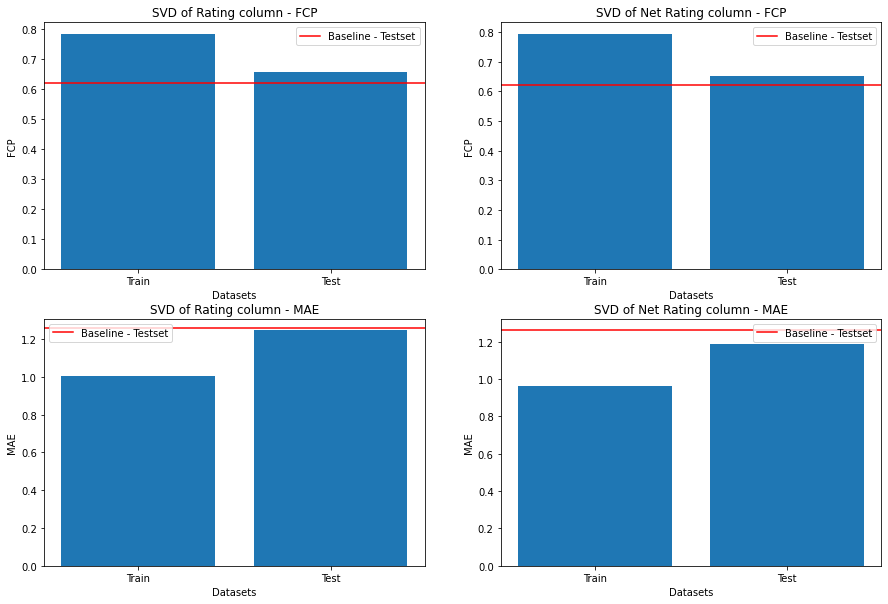

In [56]:
# Plot metrics

# Overall Variables - SVD
graph_algo = 'SVD'
graph_metric = 'fcp'

# Baseline - Approximate FCP score from Test set
baseline_fcp = 0.62 

plt.subplots(2,2, figsize = (15,10))


# Plot 1
plt.subplot(2,2,1)


# Variables
graph_col = 'Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot Baseline - Approximate FCP score from Test set
plt.axhline(y=baseline_fcp, c='r',label='Baseline - Testset')  

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()


# Plot 2
plt.subplot(2,2,2)

# Variables
graph_col = 'Net Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot Baseline - Approximate FCP score from Test set
plt.axhline(y=baseline_fcp, c='r',label='Baseline - Testset')  

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()



# Overall Variables - MAE
graph_algo = 'SVD'
graph_metric = 'mae'

# Baseline - Approximate MAE score from Test set
baseline_mae = 1.26


# Plot 3
plt.subplot(2,2,3)

# Variables
graph_col = 'Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'r')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot Baseline - Approximate MAE score from Test set
plt.axhline(y=baseline_mae, c='r',label='Baseline - Testset') 

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()

# Plot 4
plt.subplot(2,2,4)

# Variables
graph_col = 'Net Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot Baseline - Approximate MAE score from Test set
plt.axhline(y=baseline_mae, c='r',label='Baseline - Testset') 

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()


# Show the subplots
plt.tight_layout
plt.show()

##### Summary / Findings:
- As expected, the SVD model out performed our Baseline model from earlier (higher `fcp`, lower `mae`).
- The test `fcp` and `mae` for both the `rating` and `rating_net_user_mean` (net rating) columns are quite similar. 
    - `rating` column - has more favourable `fcp` score.
    - `rating_net_user_mean` (net rating) column - has more favourable `mae` score.
    
- **I will go forward with the model created with the `rating_net_user_mean` (net rating) column.** I am choosing this column since I want to see predictions that indicate whether a user liked a movie more (positive figure) or less (negative figure) than their overall average rating, and by how much (i.e. the magnitude of these positive / negative figures). 

## SVD ++ (SVDpp) Model - `rating_net_user_mean`

**SVD++ (or SVDpp)** is an extension from SVD, which takes into account **implicit ratings**. The fact that a user rates an item is in itself an indication of preference (i.e. **implicit rating**). For this dataset, the chance of a user liking an item that they have rated is higher than the chance of a user liking a random non-rated movie. 

I expect that the **SVD++** will perform better than SVD, since it takes into account **implicit ratings**.

For efficiencies when re-running the code, I have put the code in markdown and pickled the models. I have also stored scores (`fcp` and `mae`) in `df_results`, which I exported to csv (this code is in markdown as well).

As noted in the Summary / Findings above, I will only look at the `rating_net_user_mean` column (rationale above). Additionally, for the sake of run-time, I have decided to leverage the parameters of the best model from the Grid Search above. </br>
</br>
The parameters for this model will be:
- {'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005}
- note that the 'biased' parameter was removed as it is not a parameter for **SVD++ (SVDpp)**.

**Fit the model**

```python

# Set the reader with accurate rating scale
ratings_reader_user_mean = Reader(rating_scale=(-10,10))

# Set the dataset
train_dataset_user_mean = Dataset.load_from_df(df_train_ratings[['userId','movieId','rating_net_user_mean']], ratings_reader_user_mean)

# Build Full Train Set
net_user_mean_ratings_trainset = train_dataset_user_mean.build_full_trainset()

# Set the parameters for SVD
net_user_mean_ratings_svd_pp = SVDpp(n_factors=25, 
                                n_epochs=20, 
                                lr_all=0.005,  
                                verbose=5)

# Fit train set
net_user_mean_ratings_svd_pp.fit(net_user_mean_ratings_trainset)

# Pickle the model
joblib.dump(net_user_mean_ratings_svd_pp, 'DT_files/DT_net_user_mean_ratings_svd_pp.pkl')

```

The below code is for importing models. This code can be used if we want to run the fitting, prediction, and scoring below without rerunning the above.

```python

# Import models

# SVD ++ model for `net_user_mean_rating` column
net_user_mean_ratings_svd_pp = joblib.load('DT_files/DT_net_user_mean_ratings_svd_pp.pkl')

```

### Train Dataset - `rating_net_user_mean`

```python


# Filter `df_train_ratings` to - user ID, movie ID, rating
df_train_nmr = df_train_ratings[['userId','movieId','rating_net_user_mean']]

# Convert df to array to list
list_train_nmr = df_train_nmr.to_numpy().tolist()

# Predict
train_pred_nmr = net_user_mean_ratings_svd_pp.test(list_train_nmr)

# Put into a dataframe
df_train_pred_nmr_pp = pd.DataFrame(train_pred_nmr, columns=['userId', 
                                                             'movieId',
                                                             'actual_rating_net_user_mean',
                                                             'prediction',
                                                             'details'])

# Add accuracy info to `df_results`
in_algo = 'SVD_pp'
in_traintest = 'Train'
in_r_nmr ='nmr'
in_fcp = accuracy.fcp(train_pred_nmr)
in_mae = accuracy.mae(train_pred_nmr)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [57]:
# Show results 
df_results.iloc[8:9,:]

,Algo,Train/Test,R/NMR,fcp,mae
8,SVD_pp,Train,nmr,0.791501,0.9692


### Test Dataset - `rating_net_user_mean`

```python


# Filter `df_test_ratings` to - user ID, movie ID, rating
df_test_nmr = df_test_ratings[['userId','movieId','rating_net_user_mean']]

# Convert df to array to list
list_test_nmr = df_test_nmr.to_numpy().tolist()

# Predict
test_pred_nmr = net_user_mean_ratings_svd_pp.test(list_test_nmr)

# Put into a dataframe
df_test_pred_nmr_pp = pd.DataFrame(test_pred_nmr, columns=['userId', 
                                                           'movieId',
                                                           'actual_rating_net_user_mean',
                                                           'prediction',
                                                           'details'])

# Add accuracy info to `df_results`
in_algo = 'SVD_pp'
in_traintest = 'Test'
in_r_nmr ='nmr'
in_fcp = accuracy.fcp(test_pred_nmr)
in_mae = accuracy.mae(test_pred_nmr)

row_data = {'Algo': in_algo, 
            'Train/Test': in_traintest,
            'R/NMR': in_r_nmr,
            'fcp': in_fcp,
            'mae': in_mae}

# Add row data to df_results
df_results = df_results.append(row_data, ignore_index=True)

# Visualize upload
df_results.tail(1)

```

In [58]:
# Show results 
df_results.iloc[9:10,:]

,Algo,Train/Test,R/NMR,fcp,mae
9,SVD_pp,Test,nmr,0.662172,1.183633


**Save `df_results`**

At this point, I have exported `df_results`, markdown code below:

```python

# Export `df_results`
df_results.to_csv('DT_files/DT_df_results.csv')

```

**Visualize**

In [59]:
# Show SVD++ (SVDpp) results
df_results[df_results['Algo'] == 'SVD_pp']

,Algo,Train/Test,R/NMR,fcp,mae
8,SVD_pp,Train,nmr,0.791501,0.969200
9,SVD_pp,Test,nmr,0.662172,1.183633


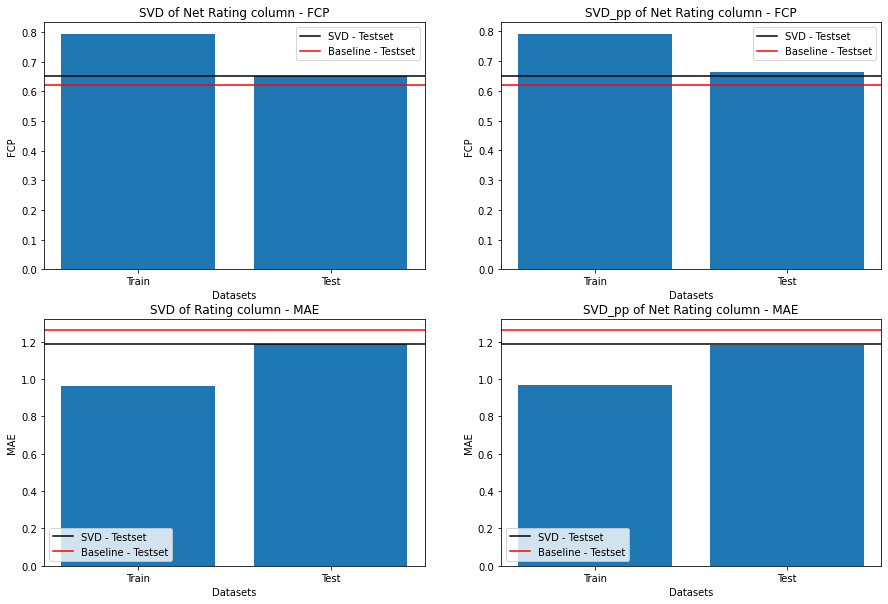

In [60]:
# Plot metrics

# Baseline - Approximate FCP score from Test set

plt.subplots(2,2, figsize = (15,10))

# Baseline - Approximate FCP score from Test set
baseline_fcp = 0.62 

# Plot 1
plt.subplot(2,2,1)

# Variables
SVD_test_fcp = 0.65
graph_algo = 'SVD'
graph_metric = 'fcp'
graph_col = 'Net Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot SVD - Approximate FCP score from Test set
plt.axhline(y=SVD_test_fcp, c='k',label='SVD - Testset')  

# Plot Baseline - Approximate FCP score from Test set
plt.axhline(y=baseline_fcp, c='r',label='Baseline - Testset')  

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()


# Plot 2
plt.subplot(2,2,2)

# Variables
SVD_test_fcp = 0.65
graph_algo = 'SVD_pp'
graph_metric = 'fcp'
graph_col = 'Net Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot SVD - Approximate FCP score from Test set
plt.axhline(y=SVD_test_fcp, c='k',label='SVD - Testset')  

# Plot Baseline - Approximate FCP score from Test set
plt.axhline(y=baseline_fcp, c='r',label='Baseline - Testset')  

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()


# Baseline - Approximate MAE score from Test set
baseline_mae = 1.26

# Plot 3
plt.subplot(2,2,3)

# Variables
SVD_test_mae = 1.1895
graph_algo = 'SVD'
graph_metric = 'mae'
graph_col = 'Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot SVD - Approximate MAE score from Test set
plt.axhline(y=SVD_test_mae, c='k',label='SVD - Testset')  

# Plot Baseline - Approximate MAE score from Test set
plt.axhline(y=baseline_mae, c='r',label='Baseline - Testset') 

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()

# Plot 4
plt.subplot(2,2,4)

# Variables
SVD_test_mae = 1.1895
graph_algo = 'SVD_pp'
graph_metric = 'mae'
graph_col = 'Net Rating'
visual_input_x = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')]['Train/Test']
visual_input_y = df_results[(df_results['Algo'] == graph_algo) & (df_results['R/NMR'] == 'nmr')][graph_metric]

# Plot Bar Graph
plt.bar(visual_input_x, visual_input_y)

# Plot SVD - Approximate MAE score from Test set
plt.axhline(y=SVD_test_mae, c='k',label='SVD - Testset')  

# Plot Baseline - Approximate MAE score from Test set
plt.axhline(y=baseline_mae, c='r',label='Baseline - Testset') 

# Titles and Axes
plt.title(f'{graph_algo} of {graph_col} column - {graph_metric.upper()}')
plt.ylabel(f'{graph_metric.upper()}')
plt.xlabel('Datasets')
plt.legend()


# Show the subplots
plt.tight_layout
plt.show()

##### Summary / Findings:
- **SVD++** versus SVD:
    - **SVD++** model slightly outperforms the SVD model as it achieved a higher `fcp` of 0.66 (versus 0.65).
    - **SVD++** model and the SVD model achieved similar `mae` of ~1.18.
- It appears that the implicit ratings helped the **SVD++** model outperform the SVD model. </br>
</br> 

**I will be using the SVD++ model to make recommendations to the various users in notebook 03_Recommendations.**

## Fullset Train & Build Anti Testset

I will build a model on the full `df_ratings` dataset. 

Build an Anti Testset, essentially all the possible combinations that do no exist in `df_ratings`. In plain English, create a dataset with combinations of users and movies in our dataset that our users have not watched yet.

I will conver the Anti Testset to a sparse matrix as it will take up less memory versus dataframes. 

For efficiencies when re-running the code, I have put the below code in markdown, as it is already saved as an NPZ file.

```python

# Set the reader with accurate rating scale
ratings_reader_user_mean = Reader(rating_scale=(-10,10))

# Set the Full Train Dataset 
full_train_dataset = Dataset.load_from_df(df_ratings[['userId','movieId','rating_net_user_mean']], ratings_reader_user_mean)

# Build Full Ratings TrainSet (with Full Train Dataset)
full_ratings_trainset = full_train_dataset.build_full_trainset()

# Build Full Ratings Anti set (with Full Ratings TrainSet)
full_ratings_anti_set = full_ratings_trainset.build_anti_testset(fill=np.nan)

```

```python

# Length of Ratings Anti set 
len(full_ratings_anti_set)

```

```python

# Recalculation of what the antiset length should be:
    # total possible combinations (unique users * unique movies) - (rows in df_ratings)
(df_ratings['userId'].nunique() * df_ratings['movieId'].nunique()) - (df_ratings.shape[0])

```

Note the above two checks equal each other so the recalculation was successful.

```python

# Convert full_ratings_anti_set into sparse matrix for export
    # Sparse matrix selected instead of CSV since it takes up less memory

# Convert into numpy array
full_anti_array = np.array(full_ratings_anti_set)

# Convert into Sparse using numpy array
full_ratings_anti_sparse = sparse.csr_matrix(full_anti_array)

```

##### Summary / Findings:
- I have successfully created the Anti Testset, which will be used to recommend movies in the 03_Recommendations notebook.

# Section 2 - Top Movies

The top movies were defined and extracted in the 01_EDA notebook. No steps necessary in this notebook.

# Section 3 - Tags-based Recommendation

In [61]:
# Number of Unique Movies 
df_tags_of_movies.shape[0]

24478

### Quick Peak into `tag` column

Below, I just want to visualize the data I'll be working with. For more details on this please see the 01_EDA notebook, where this `tag` column and `df_tags_of_movies` was created. 

In [62]:
# Look at a specific movie
df_tags_of_movies[['movieId','title','tag']][df_tags_of_movies['movieId']==480]

,movieId,title,tag
395,480,Jurassic Park (1993),action adventure Dinosaurs genetics ...


In [63]:
# Visualize the tag column for a specific movie - Jurassic Park (1993)
df_tags_of_movies['tag'][df_tags_of_movies['movieId']==480].values

array([' action    adventure    Dinosaurs    genetics    Jeff Goldblum    Sam Neill    sci-fi    science    Steven Spielberg    Suspense    90s classic    action classic    adventure    adventure    sci-fi    thriller    creepy    humorous    menacing    ominous    slick    stylized    tense    amusement park    brontosaurus    dinosaur    dna    electric fence    exotic island    island    jurassic park    paleontology    theme park    triceratops    tyrannosaurus rex    adventure    children    dinosaurs    based on a book    Steven Spielberg    Steven Spielberg    Drive In    Oscar (Best Effects - Visual Effects)    adventure    Dinosaurs    samuel l. jackson    Steven Spielberg    foqam    egg    Jeff Goldblum    Michael Crichton    John Williams    action    adventure    based on a book    cloning    dinosaur    dinosaurs    family    genetics    Jeff Goldblum    John Williams    Laura Dern    Michael Crichton    Oscar (Best Effects - Visual Effects)    Richard Attenborough    Sam

### Transform Tags Data

I am looking at user-generated tags, each token (word, in this case) is more-or-less stand-alone as they are short in nature (few or one word). Since these words are stand-alone (i.e. very little context to consider), I will mainly be looking considering the Bag of Words or TF_IDF. </br>
</br>
I expect a lot of tags would be genre related (i.e. action, sci-fi, adventure, horror, comedy etc). I want to scale down the influence of genres in my recommendations. TF-IDF inherently does this (see indepth description below). Additionally, TF-IDF scales the weights from 0 to 1. Thus, I am less concerned about movies with more tags be related to each other purely driven by their popularity (i.e. higher word count).

The vectorizer I've selected is **TF-IDF** (Term Frequency - Inverse Document Frequency). 

TF-IDF can be broken down into two parts.
1. **Term Frequency (TF)** - number of times a given token (word, in this case) appears in the `tag` column. The same as bag-of-words </br>
    *(Count the number of times it appears)*</br>
2. **Inverse Document Frequency (IDF)** - Inverse of the number of tags (grouped by each movie) a given token (word, in this case) appears in.</br>
    *(Normalize the Counts from 1 above)*</br>

The document-term (i.e. movie-tags) matrix will contain a weight for each combination, ranging from 0 to 1:
- words that are more common across tags (grouped by each movie), are going to be scaled down (i.e. have a lower number)
- words that are less common across tags (grouped by each movie), are going to be scaled up (i.e. have a higher number)

*Stop Words* </br>
I will be removing English stop words which are words that do not add much meaning (i.e. the, it, a, at, etc)

*Stemming and Lemmatization* </br>
I'm working with a collection of user-generated tags. I've decided **not** to perform stemming or lemmatization. In short, stemming and lemmatization is to help us achieve the root forms of words, which would help reduce feature names and ideally improve results (i.e. linking words which would've been treated separately). </br>
</br>
Stemming and lemmatization could be less effective for certain words if they end up grouping words that are not meant to be the same root word. Tags are short in nature (few or one word) and are typically nouns and adjectives. Stemming or lemmatization tend to excel a bit more when there are more verbs (as there are more tenses, variety of the same root word which could potentially be grouped together). As there are many proper nouns and specific adjectives in tags, I would not want to risk accidently group words that are not meant to be together. For example, "Bond" (as in "James Bond") versus bonds (as in stocks / bonds). 

I will be setting `min_df` to 10, which means the vectorizer will ignore words that appear in less than 10 movie tags. When comparing movies with *Cosine Similarity* (discussed further below), I want words that are meaningful and commonly used. This parameter essentially allows me to set that threshold.

In [64]:
# Transform data using TF-IDF 

# Initialize Vectorizer
vectorizer = TfidfVectorizer(stop_words = "english", min_df=10) 
    # ignore stop words in english (i.e. 'and', 'or', etc)
    # min_df = 10, ignore words that appear in less than 10 movies

# Fit Transform on Tags Data
TF_IDF_matrix = vectorizer.fit_transform(df_tags_of_movies['tag'])

In [65]:
# Show the words in the vectorizer
vectorizer.get_feature_names_out()

array(['007', '01', '02', ..., 'zucker', 'zwick', 'ôshima'], dtype=object)

In [66]:
# Get Matrix shape
TF_IDF_matrix.shape

(24478, 7000)

### Cosine similarity

At it's core, cosine similarity is a measure of the similarity between two non-zero vectors. In the `TF_IDF_matrix` above, each row is a movie, which contain the TF-IDF weights for each of the columns (which represent the tokens / words). The *cosine similarity* will be comparing each movie with each other (and inevitably itself). The output would be a square matrix, with the dimension being the number of movies being compared (~24K). </br>
</br>
Technically speaking, cosine similarity can be any number between -1 and 1. However, because TF-IDF produces non-negative weights (i.e. only from 0 to 1), there will not any negative cosine similarity. I can expect to see cosine similarities from 0 to 1. If the cosine similarity is closer to 1, the vectors are more similar. </br>

In [67]:
# Calculate Cosine Similarity on TFIDF matrix
tag_similarities = cosine_similarity(TF_IDF_matrix, dense_output=False)

In [68]:
# Get Matrix Shape
tag_similarities.shape

(24478, 24478)

In [69]:
# Check to see if this is a sparse matrix (for output)
tag_similarities

<24478x24478 sparse matrix of type '<class 'numpy.float64'>'
	with 144707377 stored elements in Compressed Sparse Row format>

##### Summary / Findings:
- I have successfully vectorized the tags (grouped by movie) using TF-IDF.
- I have calculated the cosine similarities between the movies based on the TF-IDF output.
- I will export `tag_similarities`, which contains the cosine similarities betwen the movies to be used in 03_Recommendations notebook.

# Section 4 - Export to CSV / NPZ

I have changed the below code to markdown format. I made this change so that I would not constantly re-write these files when rerunning this notebook.

*Files used in **03_Recommendations** notebook*

**From Section 1:**

```python

# Export - tag similarities to NPZ file
sparse.save_npz('DT_files/DT_sparse_ratings_anti.npz', full_ratings_anti_sparse)

```

*Note - there are no outputs from Section 2 to export.*

**From Section 3:**

```python

# Export - tag similarities to NPZ file
sparse.save_npz('DT_files/DT_tag_similarities.npz', tag_similarities)

```